## 1次元の畳み込みニューラルネットワークスクラッチ
畳み込みニューラルネットワーク（CNN） のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

このSprintでは1次元の 畳み込み層 を作成し、畳み込みの基礎を理解することを目指します。次のSprintでは2次元畳み込み層とプーリング層を作成することで、一般的に画像に対して利用されるCNNを完成させます。

クラスの名前はScratch1dCNNClassifierとしてください。クラスの構造などは前のSprintで作成したScratchDeepNeuralNetrowkClassifierを参考にしてください。

#### 1次元畳み込み層とは
CNNでは画像に対しての2次元畳み込み層が定番ですが、ここでは理解しやすくするためにまずは1次元畳み込み層を実装します。1次元畳み込みは実用上は自然言語や波形データなどの 系列データ で使われることが多いです。

畳み込みは任意の次元に対して考えることができ、立体データに対しての3次元畳み込みまではフレームワークで一般的に用意されています。

#### データセットの用意
検証には引き続きMNISTデータセットを使用します。1次元畳み込みでは全結合のニューラルネットワークと同様に平滑化されたものを入力します。

In [1]:
import numpy as np
#import cupy as np
#import chainer.cuda
from keras.datasets import mnist
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from copy import deepcopy

# データの読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# ラベルをone-hot化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

# 分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
y_train = y_train.astype(int)
y_val = y_val.astype(int)

# cupy用
# X_train = np.array(X_train)
# X_val = np.array(X_val)
# y_train = np.array(y_train)
# y_val = np.array(y_val)


Using TensorFlow backend.


### 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成
チャンネル数を1に限定した1次元畳み込み層のクラスSimpleConv1dを作成してください。基本構造は前のSprintで作成した全結合層のFCクラスと同じになります。なお、重みの初期化に関するクラスは必要に応じて作り変えてください。Xavierの初期値などを使う点は全結合層と同様です。

ここでは パディング は考えず、ストライド も1に固定します。また、複数のデータを同時に処理することも考えなくて良く、バッチサイズは1のみに対応してください。この部分の拡張はアドバンス課題とします。

フォワードプロパゲーションの数式は以下のようになります。
$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$

$a_i$ : 出力される配列のi番目の値

$F$ : フィルタのサイズ

$x_{(i+s)}$ : 入力の配列の(i+s)番目の値

$w_s$ : 重みの配列のs番目の値

$b$ : バイアス項

全てスカラーです。

次に更新式です。ここがAdaGradなどに置き換えられる点は全結合層と同様です。
$$
w_s'=w_s-\alpha\frac{\partial L}{\partial w_s} \\
b'=b-\alpha\frac{\partial L}{\partial b}
$$

$\alpha$ : 学習率

$\frac{\partial L}{\partial w_s}$ : $w_s$ に関する損失 $L$ の勾配

$\frac{\partial L}{\partial b}$ : $b$ に関する損失 $L$ の勾配

勾配 $\frac{\partial L}{\partial w_s}$ や $\frac{\partial L}{\partial b}$ を求めるためのバックプロパゲーションの数式が以下です。
$$
\frac{\partial L}{\partial w_s}=\sum_{i=0}^{N_{out}-1}\frac{\partial L}{\partial a_i}x_{(1+s)} \\
\frac{\partial L}{\partial b}=\sum_{i=0}^{N_{out}-1}\frac{\partial L}{\partial a_i}
$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi番目の値

$N_{out}$ : 出力のサイズ

前の層に流す誤差の数式は以下です。
$$
\frac{\partial L}{\partial x_j}=\sum_{s=0}^{F-1}\frac{\partial L}{\partial a_{(j-s)}}w_s
$$

$\frac{\partial L}{\partial x_j}$ : 前の層に流す誤差の配列のj番目の値

ただし、 $j-s<0$ または $j-s>N_{out}-1$ のとき $\frac{\partial L}{\partial a_{(j-s)}} =0$ です。

全結合層との大きな違いは、重みが複数の特徴量に対して共有されていることです。この場合は共有されている分の誤差を全て足すことで勾配を求めます。計算グラフ上での分岐はバックプロパゲーションの際に誤差の足し算をすれば良いことになります。

filter_info:(filter_num, filtersize)

In [2]:
class XavierInitializer:
    def __init__(self):
        self.sigma = None
    def W(self, filter_info):
        filter_num, filtersize = filter_info
        self.sigma = 1 / np.sqrt(filter_num)
        W = self.sigma * np.random.randn(filter_num, filtersize)
        return W
    def B(self, filter_info):
        filter_num, filtersize = filter_info
        B = np.zeros(filter_num)
        return B


class HeInitializer:
    def __init__(self):
        self.sigma = None
    def W(self, filter_info):
        filter_num, filtersize = filter_info
        self.sigma = np.sqrt(2 / filter_num)
        W = self.sigma * np.random.randn(filter_num, filtersize)
        return W
    def B(self, filter_info):
        filter_num, filtersize = filter_info
        B = np.zeros(filter_num)
        return B


class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.W -= self.lr * layer.dW
        layer.b -= self.lr * layer.db
        
        
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.h_W = None
        self.h_b = None
    def update(self, layer):
        if (self.h_W is None) and (self.h_b is None):
            self.h_W = 0
            self.h_b = 0
        
        self.h_W += (layer.dW ** 2).sum()
        self.h_b += (layer.db ** 2).sum()
        layer.W -= self.lr * layer.dW / (np.sqrt(self.h_W) + 1e-7)
        layer.b -= self.lr * layer.db / (np.sqrt(self.h_b) + 1e-7)

In [3]:
class SimpleConv1d:
    def __init__(self, filter_info, initializer, optimizer):
        self.optimizer = deepcopy(optimizer)
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(filter_info)
        self.b = initializer.B(filter_info)
        self.X = None
        self.dW = None
        self.db = None

    def forward(self, X):
        filter_num, filtersize = self.W.shape
        self.X = X
        # フィルターと内積を取る全ての要素(col)を導出
        out_width = X.shape[1] - filtersize + 1
        col = np.zeros((X.shape[0], filtersize, out_width))

        for width in range(filtersize):
            width_max = width + out_width
            col[:, width, :] = X[:, width:width_max]
        
        col = col.transpose(0, 2, 1).reshape(X.shape[0]*out_width, -1)
        self.col = col
        
        # colと計算できるように変形
        col_W = self.W.reshape(filter_num, -1).T
        self.col_W = col_W

        out = np.dot(col, col_W) + self.b
        
        # (サンプル数, フィルターと畳み込んだ要素)の形にする
        out = out.reshape(X.shape[0], out_width, -1).transpose(0, 2, 1)
        
        return out

    def backward(self, dA):
        filter_num, filtersize = self.W.shape
        dA = dA.transpose(0, 2, 1).reshape(-1, filter_num)
        
        self.db = np.sum(dA, axis=0)
        self.dW = np.dot(self.col.T, dA)
        self.dW = self.dW.transpose(1, 0).reshape(filter_num, filtersize)
        
        dcol = np.dot(dA, self.col_W.T)
        
        # フィルターと内積を取った全ての要素を元イメージの形に変換
        out_width = self.X.shape[1] - filtersize + 1
        dcol = dcol.reshape(self.X.shape[0], out_width, filtersize).transpose(0, 2, 1)
        
        dX = np.zeros(self.X.shape)
        
        for width in range(filtersize):
            width_max = width + out_width
            dX[:, width:width_max] += dcol[:, width, :]

        self.optimizer.update(self)
        
        return dX


In [4]:
filter_info = (1, 780)
initializer = HeInitializer()
optimizer = AdaGrad(lr=0.01)

conv = SimpleConv1d(filter_info, initializer, optimizer)
out = conv.forward(X_train[:3])
print(out.shape)
conv.backward(np.array([[[-2, -1, -3, -1, 2],[-2, -1, -3, -1, 2],[-2, -1, -3, -1, 2]]]))

(3, 1, 5)


array([[-0.46941314, -5.97876848, -6.08885051, ...,  0.23189721,
        -0.16132301, -0.47157834],
       [-0.23470657, -3.45879738, -9.02319373, ...,  0.38082953,
        -1.10447968, -0.47157834],
       [-0.23470657, -2.98938424, -2.34030554, ..., -1.40695109,
         0.32264602,  0.94315667]])

### 【問題2】1次元畳み込み後の出力サイズの計算
畳み込みを行うと特徴量の数が変化します。どのように変化するかは以下の数式から求められます。パディングやストライドも含めています。この計算を行う関数を作成してください。
$$
N_{out}=\frac{N_{im}+2P-F}{S}+1
$$

$N_{out}$ : 出力のサイズ（特徴量の数）

$N_{in}$ : 入力のサイズ（特徴量の数）

$P$ : ある方向へのパディングの数

$F$ : フィルタのサイズ

$S$ : ストライドのサイズ

In [5]:
def calculate_output_size(N_in, paddingSize, filterSize, strideSize):
    N_out = (N_in + 2*paddingSize - filterSize)//strideSize + 1
    return N_out

In [6]:
calculate_output_size(10, 0, 8, 1)

3

In [7]:
calculate_output_size(10, 1, 8, 1)

5

### 【問題3】小さな配列での1次元畳み込み層の実験
次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。

入力x、重みw、バイアスbを次のようにします。
```
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])
```

フォワードプロパゲーションをすると出力は次のようになります。
```
a = np.array([35, 50])
```

次にバックプロパゲーションを考えます。誤差は次のようであったとします。
```
delta_a = np.array([10, 20])
```

バックプロパゲーションをすると次のような値になります。
```
delta_b = np.array([30])
delta_w = np.array([50, 80, 110])
delta_x = np.array([30, 110, 170, 140])
```

#### 実装上の工夫
畳み込みを実装する場合は、まずはfor文を重ねていく形で構いません。しかし、できるだけ計算は効率化させたいため、以下の式を一度に計算する方法を考えることにします。
$$
a_i=\sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$

バイアス項は単純な足し算のため、重みの部分を見ます。
$$
\sum_{s=0}^{F-1}x_{(i+s)}w_s
$$

これは、xの一部を取り出した配列とwの配列の内積です。具体的な状況を考えると、以下のようなコードで計算できます。この例では流れを分かりやすくするために、各要素同士でアダマール積を計算してから合計を計算しています。これは結果的に内積と同様です。
```
x = np.array([1, 2, 3, 4])
w = np.array([3, 5, 7])
a = np.empty((2, 3))
indexes0 = np.array([0, 1, 2]).astype(np.int)
indexes1 = np.array([1, 2, 3]).astype(np.int)
a[0] = x[indexes0]*w # x[indexes0]は([1, 2, 3])である
a[1] = x[indexes1]*w # x[indexes1]は([2, 3, 4])である
a = a.sum(axis=1)
```

ndarrayは配列を使ったインデックス指定ができることを利用した方法です。

また、二次元配列を使えば一次元配列から二次元配列が取り出せます。
```
x = np.array([1, 2, 3, 4])
indexes = np.array([[0, 1, 2], [1, 2, 3]]).astype(np.int)
print(x[indexes]) # ([[1, 2, 3], [2, 3, 4]])
```

このこととブロードキャストなどをうまく組み合わせることで、一度にまとめて計算することも可能です。

畳み込みの計算方法に正解はないので、自分なりに効率化していってください。

《参考》

以下のページのInteger array indexingの部分がこの方法についての記述です。

[Indexing — NumPy v1.17 Manual](https://numpy.org/doc/stable/reference/arrays.indexing.html)

In [8]:
class SimpleConv1d_test:
    def __init__(self, filter_info, initializer, optimizer):
        self.optimizer = deepcopy(optimizer)
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = np.array([[3, 5, 7]]).astype(float)
        self.b = np.array([[1]]).astype(float)
        self.X = None
        self.dW = None
        self.db = None

    def forward(self, X):
        filter_num, filtersize = self.W.shape
        self.X = X
        # フィルターと内積を取る全ての要素(col)を導出
        out_width = X.shape[1] - filtersize + 1
        col = np.zeros((X.shape[0], filtersize, out_width))

        for width in range(filtersize):
            width_max = width + out_width
            col[:, width, :] = X[:, width:width_max]
        
        col = col.transpose(0, 2, 1).reshape(X.shape[0]*out_width, -1)
        self.col = col
        
        # colと計算できるように変形
        col_W = self.W.reshape(filter_num, -1).T
        self.col_W = col_W

        out = np.dot(col, col_W) + self.b
        
        # (サンプル数, フィルターと畳み込んだ要素)の形にする
        out = out.reshape(X.shape[0], out_width, -1).transpose(0, 2, 1)
        
        return out

    def backward(self, dA):
        filter_num, filtersize = self.W.shape
        dA = dA.transpose(0, 2, 1).reshape(-1, filter_num)
        
        self.db = np.sum(dA, axis=0)
        self.dW = np.dot(self.col.T, dA)
        self.dW = self.dW.transpose(1, 0).reshape(filter_num, filtersize)
        
        dcol = np.dot(dA, self.col_W.T)
        # フィルターと内積を取った全ての要素を元イメージの形に変換
        out_width = self.X.shape[1] - filtersize + 1
        dcol = dcol.reshape(self.X.shape[0], out_width, filtersize).transpose(0, 2, 1)
        dX = np.zeros(self.X.shape)
        
        for width in range(filtersize):
            width_max = width + out_width
            dX[:, width:width_max] += dcol[:, width, :]

        self.optimizer.update(self)
        
        return dX


In [9]:
test_filter_info = (5, 700)
test_initializer = HeInitializer()
test_optimizer = AdaGrad(lr=0.01)

test_conv = SimpleConv1d_test(test_filter_info, test_initializer, test_optimizer)
out = test_conv.forward(np.array([[1,2,3,4]]))
print(out)
dout = test_conv.backward(np.array([[[10, 20]]]))
print(test_conv.db)
print(test_conv.dW)
print(dout)

[[[35. 50.]]]
[30]
[[ 50.  80. 110.]]
[[ 30. 110. 170. 140.]]


### 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成
チャンネル数を1に限定しない1次元畳み込み層のクラスConv1dを作成してください。

例えば以下のようなx, w, bがあった場合は、
```
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）
```

出力は次のようになります。
```
a = np.array([[16, 22], [17, 23], [18, 24]]) # shape(3, 2)で、（出力チャンネル数、特徴量数）である。
```

入力が2チャンネル、出力が3チャンネルの例です。計算グラフを書いた上で、バックプロパゲーションも手計算で考えてみましょう。計算グラフの中には和と積しか登場しないので、微分を新たに考える必要はありません。

《補足》

チャンネル数を加える場合、配列をどういう順番にするかという問題があります。(バッチサイズ、チャンネル数、特徴量数)または(バッチサイズ、特徴量数、チャンネル数)が一般的で、ライブラリによって順番は異なっています。（切り替えて使用できるものもあります）

今回のスクラッチでは自身の実装上どちらが効率的かを考えて選んでください。上記の例ではバッチサイズは考えておらず、(チャンネル数、特徴量数)です。

filter_info:(filter_num, channel, filtersize)

In [10]:
class Conv1d:
    def __init__(self, filter_info, initializer, optimizer):
        self.optimizer = deepcopy(optimizer)
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(filter_info)
        self.b = initializer.B(filter_info)
        self.X = None
        self.dW = None
        self.db = None

    def forward(self, X):
        filter_num, channel_in, filtersize = self.W.shape
        self.X = X
        # フィルターと内積を取る全ての要素(col)を導出
        out_width = X.shape[2] - filtersize + 1
        col = np.zeros((X.shape[0], channel_in, filtersize, out_width))

        for width in range(filtersize):
            width_max = width + out_width
            col[:, :, width, :] = X[:, :, width:width_max]
        
        col = col.transpose(0, 1, 3, 2).reshape(X.shape[0]*out_width, -1)
        self.col = col
        
        # colと計算できるように変形
        col_W = self.W.reshape(filter_num, -1).T
        self.col_W = col_W
        out = np.dot(col, col_W) + self.b
        
        # (サンプル数, フィルターと畳み込んだ要素)の形にする
        out = out.reshape(X.shape[0], out_width, -1).transpose(0, 2, 1)
        
        return out

    def backward(self, dA):
        filter_num, channel_in, filtersize = self.W.shape
        dA = dA.transpose(0, 2, 1).reshape(-1, filter_num)
        self.db = np.sum(dA, axis=0)
        self.dW = np.dot(self.col.T, dA)
        self.dW = self.dW.transpose(1, 0).reshape(filter_num, channel_in, filtersize)
        
        dcol = np.dot(dA, self.col_W.T)
        # フィルターと内積を取った全ての要素を元イメージの形に変換
        out_width = self.X.shape[2] - filtersize + 1
        dcol = dcol.reshape(self.X.shape[0], out_width, channel_in, filtersize).transpose(0, 2, 3, 1)
        dX = np.zeros(self.X.shape)
        for width in range(filtersize):
            width_max = width + out_width
            dX[:, :, width:width_max] += dcol[:, :, width, :]

        self.optimizer.update(self)
        
        return dX


In [13]:
class Conv1d_test:
    def __init__(self, filter_info, initializer, optimizer):
        self.optimizer = deepcopy(optimizer)
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = np.ones((3, 2, 3)).astype(float)
        self.b = np.array([1, 2, 3]).astype(float)
        self.X = None
        self.dW = None
        self.db = None

    def forward(self, X):
        filter_num, channel_in, filtersize = self.W.shape
        self.X = X
        # フィルターと内積を取る全ての要素(col)を導出
        out_width = X.shape[2] - filtersize + 1
        col = np.zeros((X.shape[0], channel_in, filtersize, out_width))

        for width in range(filtersize):
            width_max = width + out_width
            col[:, :, width, :] = X[:, :, width:width_max]
        
        col = col.transpose(0, 1, 3, 2).reshape(X.shape[0]*out_width, -1)
        self.col = col
        
        # colと計算できるように変形
        col_W = self.W.reshape(filter_num, -1).T
        self.col_W = col_W
        out = np.dot(col, col_W) + self.b
        
        # (サンプル数, フィルターと畳み込んだ要素)の形にする
        out = out.reshape(X.shape[0], out_width, -1).transpose(0, 2, 1)
        
        return out

    def backward(self, dA):
        filter_num, channel_in, filtersize = self.W.shape
        dA = dA.transpose(0, 2, 1).reshape(-1, filter_num)
        self.db = np.sum(dA, axis=0)
        self.dW = np.dot(self.col.T, dA)
        self.dW = self.dW.transpose(1, 0).reshape(filter_num, channel_in, filtersize)
        
        dcol = np.dot(dA, self.col_W.T)
        # フィルターと内積を取った全ての要素を元イメージの形に変換
        out_width = self.X.shape[2] - filtersize + 1
        dcol = dcol.reshape(self.X.shape[0], out_width, channel_in, filtersize).transpose(0, 2, 3, 1)
        dX = np.zeros(self.X.shape)
        for width in range(filtersize):
            width_max = width + out_width
            dX[:, :, width:width_max] += dcol[:, :, width, :]

        self.optimizer.update(self)
        
        return dX

In [14]:
test_filter_info = (5, 700)
test_initializer = HeInitializer()
test_optimizer = AdaGrad(lr=0.01)

test_conv = Conv1d_test(test_filter_info, test_initializer, test_optimizer)
out = test_conv.forward(np.array([[[1, 2, 3, 4], [2, 3, 4, 5]]]))
print(out)
dout = test_conv.backward(np.array([[[10, 11],[20, 21],[30, 31]]]))
print(test_conv.db)
print(test_conv.dW)
print(dout)

[[[16. 22.]
  [17. 23.]
  [18. 24.]]]
[21 41 61]
[[[ 32.  53.  74.]
  [ 53.  74.  95.]]

 [[ 62. 103. 144.]
  [103. 144. 185.]]

 [[ 92. 153. 214.]
  [153. 214. 275.]]]
[[[ 60. 123. 123.  63.]
  [ 60. 123. 123.  63.]]]


### 【問題5】（アドバンス課題）パディングの実装
畳み込み層にパディングの機能を加えてください。1次元配列の場合、前後にn個特徴量を増やせるようにしてください。

最も単純なパディングは全て0で埋める ゼロパディング であり、CNNでは一般的です。他に端の値を繰り返す方法などもあります。

フレームワークによっては、元の入力のサイズを保つようにという指定をすることができます。この機能も持たせておくと便利です。なお、NumPyにはパディングの関数が存在します。

[numpy.pad — NumPy v1.17 Manual](https://numpy.org/doc/stable/reference/generated/numpy.pad.html)

- Initializerについて、チャンネルの概念が増えたため対応
- Conv1dのコンストラクタ引数にpadを追加
- Conv1dをリファクタリング

In [16]:
class XavierInitializer_conv:
    def __init__(self):
        self.sigma = None
    def W(self, filter_info):
        filter_num, channel_in, filtersize = filter_info
        self.sigma = 1 / np.sqrt(filter_num)
        W = self.sigma * np.random.randn(filter_num, channel_in, filtersize)
        return W
    def B(self, filter_info):
        filter_num, channel_in, filtersize = filter_info
        B = np.zeros(filter_num)
        return B


class HeInitializer_conv:
    def __init__(self):
        self.sigma = None
    def W(self, filter_info):
        filter_num, channel_in, filtersize = filter_info
        self.sigma = np.sqrt(2 / filter_num)
        W = self.sigma * np.random.randn(filter_num, channel_in, filtersize)
        return W
    def B(self, filter_info):
        filter_num, channel_in, filtersize = filter_info
        B = np.zeros(filter_num)
        return B

In [17]:
class Conv1d:
    def __init__(self, filter_info, initializer, optimizer, pad=0):
        self.optimizer = deepcopy(optimizer)
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(filter_info)
        self.b = initializer.B(filter_info)
        self.X = None
        self.dW = None
        self.db = None
        self.pad = pad
        self.out_width = None

    def forward(self, X):
        filter_num, channel_in, filtersize = self.W.shape
        X = X.reshape(X.shape[0], channel_in, X.shape[-1])
        self.out_width = X.shape[-1] + 2*self.pad - filtersize + 1
        X = np.pad(X, [(0,0), (0,0), (self.pad,self.pad)], 'constant')
        self.X = X
        col = np.zeros((X.shape[0], channel_in, filtersize, self.out_width))
        
        for width in range(filtersize):
            width_max = width + self.out_width
            col[:, :, width, :] = X[:, :, width:width_max]
        
        col = col.transpose(0, 1, 3, 2).reshape(X.shape[0]*self.out_width, -1)
        self.col = col
        
        # colと計算できるように変形
        col_W = self.W.reshape(filter_num, -1).T
        self.col_W = col_W
        out = np.dot(col, col_W) + self.b
        
        # (サンプル数, フィルターと畳み込んだ要素)の形にする
        out = out.reshape(X.shape[0], self.out_width, -1).transpose(0, 2, 1)
        
        return out

    def backward(self, dA):
        filter_num, channel_in, filtersize = self.W.shape
        dA = dA.transpose(0, 2, 1).reshape(-1, filter_num)
        self.db = np.sum(dA, axis=0)
        self.dW = np.dot(self.col.T, dA)
        self.dW = self.dW.transpose(1, 0).reshape(filter_num, channel_in, filtersize)
        
        dcol = np.dot(dA, self.col_W.T)
        # フィルターと内積を取った全ての要素を元イメージの形に変換
        dcol = dcol.reshape(self.X.shape[0], self.out_width, channel_in, filtersize).transpose(0, 2, 3, 1)
        dX = np.zeros(self.X.shape)
        for width in range(filtersize):
            width_max = width + self.out_width
            dX[:, :, width:width_max] += dcol[:, :, width, :]

        self.optimizer.update(self)
        
        return dX


In [19]:
filter_info = (1, 1, 780)
initializer = HeInitializer_conv()
optimizer = AdaGrad(lr=0.01)

conv = Conv1d(filter_info, initializer, optimizer, pad=1)
out = conv.forward(X_train[:3])
print(out.shape)
dout = conv.backward(np.array([[[-2, -1, -3, -1, 2, 1, 1],[-2, -1, -3, -1, 2, 1, 1],[-2, -1, -3, -1, 2, 1, 1]]]))
print(dout.shape)
print(conv.db.shape)
print(conv.dW.shape)

(3, 1, 7)
(3, 1, 786)
(1,)
(1, 1, 780)


### 【問題6】（アドバンス課題）ミニバッチへの対応
ここまでの課題はバッチサイズ1で良いとしてきました。しかし、実際は全結合層同様にミニバッチ学習が行われます。Conv1dクラスを複数のデータが同時に計算できるように変更してください。

- 対応済み

### 【問題7】（アドバンス課題）任意のストライド数
ストライドは1限定の実装をしてきましたが、任意のストライド数に対応できるようにしてください。

- Conv1dのコンストラクタ引数にstrideを追加
- Conv1dをリファクタリング

In [20]:
class Conv1d:
    def __init__(self, filter_info, initializer, optimizer, pad=0, stride=1):
        self.optimizer = deepcopy(optimizer)
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(filter_info)
        self.b = initializer.B(filter_info)
        self.X = None
        self.dW = None
        self.db = None
        self.pad = pad
        self.out_width = None
        self.stride = stride

    def forward(self, X):
        filter_num, channel_in, filtersize = self.W.shape
        X = X.reshape(X.shape[0], channel_in, X.shape[-1])
        self.out_width = (X.shape[-1] + 2*self.pad - filtersize)//self.stride + 1
        X = np.pad(X, [(0,0), (0,0), (self.pad,self.pad)], 'constant')
        self.X = X
        col = np.zeros((X.shape[0], channel_in, filtersize, self.out_width))
        
        for width in range(filtersize):
            width_max = width + self.stride*self.out_width
            col[:, :, width, :] = X[:, :, width:width_max:self.stride]
        
        col = col.transpose(0, 1, 3, 2).reshape(X.shape[0]*self.out_width, -1)
        self.col = col
        
        # colと計算できるように変形
        col_W = self.W.reshape(filter_num, -1).T
        self.col_W = col_W
        out = np.dot(col, col_W) + self.b
        
        # (サンプル数, フィルターと畳み込んだ要素)の形にする
        out = out.reshape(X.shape[0], self.out_width, -1).transpose(0, 2, 1)
        
        return out

    def backward(self, dA):
        filter_num, channel_in, filtersize = self.W.shape
        dA = dA.transpose(0, 2, 1).reshape(-1, filter_num)
        self.db = np.sum(dA, axis=0)
        self.dW = np.dot(self.col.T, dA)
        self.dW = self.dW.transpose(1, 0).reshape(filter_num, channel_in, filtersize)
        
        dcol = np.dot(dA, self.col_W.T)
        # フィルターと内積を取った全ての要素を元イメージの形に変換
        dcol = dcol.reshape(self.X.shape[0], self.out_width, channel_in, filtersize).transpose(0, 2, 3, 1)
        dX = np.zeros((self.X.shape[0], self.X.shape[1], self.X.shape[2] + self.stride - 1))
        for width in range(filtersize):
            width_max = width + self.stride*self.out_width
            dX[:, :, width:width_max:self.stride] += dcol[:, :, width, :]

        self.optimizer.update(self)
        
        return dX


In [22]:
filter_info = (1, 1, 780)
initializer = HeInitializer_conv()
optimizer = AdaGrad(lr=0.01)

conv = Conv1d(filter_info, initializer, optimizer, pad=2, stride=2)
out = conv.forward(X_train[:3])
print(out.shape)
dout = conv.backward(np.array([[[-2, -1, -3, -1, 1],[-2, -1, -3, -1, 1],[-2, -1, -3, -1, 1]]]))
print(dout.shape)
print(conv.db.shape)
print(conv.dW.shape)

(3, 1, 5)
(3, 1, 789)
(1,)
(1, 1, 780)


In [25]:
class Conv1d_test:
    def __init__(self, filter_info, initializer, optimizer, pad=0, stride=1):
        self.optimizer = deepcopy(optimizer)
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = np.ones((3, 2, 3)).astype(float)
        self.b = np.array([1, 2, 3]).astype(float)
        self.X = None
        self.dW = None
        self.db = None
        self.pad = pad
        self.out_width = None
        self.stride = stride

    def forward(self, X):
        filter_num, channel_in, filtersize = self.W.shape
        X = X.reshape(X.shape[0], channel_in, X.shape[-1])
        self.out_width = (X.shape[-1] + 2*self.pad - filtersize)//self.stride + 1
        X = np.pad(X, [(0,0), (0,0), (self.pad,self.pad)], 'constant')
        self.X = X
        col = np.zeros((X.shape[0], channel_in, filtersize, self.out_width))
        
        for width in range(filtersize):
            width_max = width + self.stride*self.out_width
            col[:, :, width, :] = X[:, :, width:width_max:self.stride]
        
        col = col.transpose(0, 1, 3, 2).reshape(X.shape[0]*self.out_width, -1)
        self.col = col
        
        # colと計算できるように変形
        col_W = self.W.reshape(filter_num, -1).T
        self.col_W = col_W
        out = np.dot(col, col_W) + self.b
        
        # (サンプル数, フィルターと畳み込んだ要素)の形にする
        out = out.reshape(X.shape[0], self.out_width, -1).transpose(0, 2, 1)
        
        return out

    def backward(self, dA):
        filter_num, channel_in, filtersize = self.W.shape
        dA = dA.transpose(0, 2, 1).reshape(-1, filter_num)
        self.db = np.sum(dA, axis=0)
        self.dW = np.dot(self.col.T, dA)
        self.dW = self.dW.transpose(1, 0).reshape(filter_num, channel_in, filtersize)
        
        dcol = np.dot(dA, self.col_W.T)
        # フィルターと内積を取った全ての要素を元イメージの形に変換
        dcol = dcol.reshape(self.X.shape[0], self.out_width, channel_in, filtersize).transpose(0, 2, 3, 1)
        dX = np.zeros((self.X.shape[0], self.X.shape[1], self.X.shape[2] + self.stride - 1))
        for width in range(filtersize):
            width_max = width + self.stride*self.out_width
            dX[:, :, width:width_max:self.stride] += dcol[:, :, width, :]

        self.optimizer.update(self)
        
        return dX


In [26]:
test_optimizer = AdaGrad(lr=0.01)

test_conv = Conv1d_test(test_filter_info, test_initializer, test_optimizer, pad=0, stride=1)
out = test_conv.forward(np.array([[[1, 2, 3, 4], [2, 3, 4, 5]]]))
print(out)
dout = test_conv.backward(np.array([[[10,11],[20,21],[30,31]]]))
print(test_conv.db)
print(test_conv.dW)
print(dout)

[[[16. 22.]
  [17. 23.]
  [18. 24.]]]
[21 41 61]
[[[ 32.  53.  74.]
  [ 53.  74.  95.]]

 [[ 62. 103. 144.]
  [103. 144. 185.]]

 [[ 92. 153. 214.]
  [153. 214. 275.]]]
[[[ 60. 123. 123.  63.]
  [ 60. 123. 123.  63.]]]


### 【問題8】学習と推定
これまで使ってきたニューラルネットワークの全結合層の一部をConv1dに置き換えてMNISTを学習・推定し、Accuracyを計算してください。

出力層だけは全結合層をそのまま使ってください。ただし、チャンネルが複数ある状態では全結合層への入力は行えません。その段階でのチャンネルは1になるようにするか、 平滑化 を行なってください。

画像に対しての1次元畳み込みは実用上は行わないことのため、精度は問いません。

- Sprint_10よりFC, Relu, Softmax, ScratchDeepNeuralNetrowkClassifier, XavierInitializer, HeInitializerを流用
- ScratchDeepNeuralNetrowkClassifierをリファクタリング
- Conv1dに1次元専用処理を追加

In [29]:
from copy import deepcopy

class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = deepcopy(optimizer)
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.b = initializer.B(n_nodes2)
        self.X = None
        self.dW = None
        self.db = None

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        self.X = X
        out = np.dot(X, self.W) + self.b
        
        return out

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # 更新
        batch_size = dA.shape[0]
        dX = np.dot(dA, self.W.T)
        self.dW = np.dot(self.X.T, dA) / batch_size
        self.db = np.sum(dA, axis=0) / batch_size
        self = self.optimizer.update(self)
        
        return dX


class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x < 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

    
class Softmax():
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    
    def _softmax(self, X):
        X = X - np.max(X, axis=-1, keepdims=True)
        y = np.exp(X) / np.sum(np.exp(X), axis=-1, keepdims=True)
        
        return y
    
    def _cross_entropy_error(self, y, t):
        batch_size = y.shape[0]
        
        return -np.sum(t * np.log(y + 1e-7)) / batch_size
    
    def forward(self, X, t):
        self.t = t
        self.y = self._softmax(X)
        self.loss = self._cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dX = (self.y - self.t) / batch_size
        
        return dX

    
class XavierInitializer:
    def __init__(self):
        self.sigma = None
    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1 / np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = np.zeros(n_nodes2)
        return B


class HeInitializer:
    def __init__(self):
        self.sigma = None
    def W(self, n_nodes1, n_nodes2):
        self.sigma = np.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = np.zeros(n_nodes2)
        return B

    
from collections import OrderedDict

class ScratchDeepNeuralNetrowkClassifier():
    def __init__(self, lr, verbose=True, batch_size=20, max_iter=3):
        self.verbose = verbose
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.list_train_loss = []
        self.list_test_loss = []
        # レイヤの生成
        initializer = XavierInitializer()
        initializer_conv = XavierInitializer_conv()
        optimizer = SGD(lr=lr)
        self.layers = OrderedDict()
        filter_info = (1, 1, 685)
        self.layers["Conv1d"] = Conv1d(filter_info, initializer_conv, optimizer, pad=0, stride=1)
        self.layers["ReLU"] = Relu()
        self.layers["FC"] = FC(100, 10, initializer, optimizer)
        self.lastLayer = Softmax()
    
    def fit(self, X, y, X_val=None, y_val=None):
        flg_test = 0
        if (X_val is not None) and (y_val is not None):
            flg_test = 1

        # 1エポックの繰り返し数
        iter_num = int(len(X) / self.batch_size)
            
        # エポックを複数回繰り返す
        for i_ in range(self.max_iter):
            # 損失計算用
            tmp_list_loss_train = []
            tmp_list_loss_val = []

            # 1エポック
            for j_ in range(iter_num):
                batch_mask = np.random.choice(X.shape[0], self.batch_size)
                batch_mask_val = np.random.choice(X_val.shape[0], self.batch_size)
                X_batch = X[batch_mask]
                y_batch = y[batch_mask]
                X_val_batch = X_val[batch_mask_val]
                y_val_batch = y_val[batch_mask_val]
                
                self._gradient(X_batch, y_batch)
                
                loss_train = self._loss(X_batch, y_batch)
                tmp_list_loss_train.append(loss_train)
                if flg_test == 1:
                    loss_test = self._loss(X_val_batch, y_val_batch)
                    tmp_list_loss_val.append(loss_test)
                    
                if self.verbose:
                    #verboseをTrueにした際は学習過程などを出力する
                    print("loss_train:{}".format(loss_train))
                    print("loss_test:{}".format(loss_test))
            
            # 損失をインスタンス領域に設定
            self.list_train_loss.append(sum(tmp_list_loss_train)/len(tmp_list_loss_train))
            self.list_test_loss.append(sum(tmp_list_loss_val)/len(tmp_list_loss_val))
                
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        for layer in self.layers.values():
            X = layer.forward(X)
            
        pred = np.argmax(X, axis=1)
        
        return pred
    
    def _loss(self, X, t):
        for layer in self.layers.values():
            X = layer.forward(X)

        return self.lastLayer.forward(X, t)

    def _gradient(self, X, t):
        self._loss(X, t)
        
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
                    
        return
    

class Conv1d:
    def __init__(self, filter_info, initializer, optimizer, pad=0, stride=1):
        self.optimizer = deepcopy(optimizer)
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(filter_info)
        self.b = initializer.B(filter_info)
        self.X = None
        self.dW = None
        self.db = None
        self.pad = pad
        self.out_width = None
        self.stride = stride

    def forward(self, X):
        filter_num, channel_in, filtersize = self.W.shape
        X = X.reshape(X.shape[0], channel_in, X.shape[-1])
        self.out_width = (X.shape[-1] + 2*self.pad - filtersize)//self.stride + 1
        X = np.pad(X, [(0,0), (0,0), (self.pad,self.pad)], 'constant')
        self.X = X
        col = np.zeros((X.shape[0], channel_in, filtersize, self.out_width))
        
        for width in range(filtersize):
            width_max = width + self.stride*self.out_width
            col[:, :, width, :] = X[:, :, width:width_max:self.stride]
        
        col = col.transpose(0, 1, 3, 2).reshape(X.shape[0]*self.out_width, -1)
        self.col = col
        
        # colと計算できるように変形
        col_W = self.W.reshape(filter_num, -1).T
        self.col_W = col_W
        out = np.dot(col, col_W) + self.b
        
        # (サンプル数, フィルターと畳み込んだ要素)の形にする
        out = out.reshape(X.shape[0], self.out_width, -1).transpose(0, 2, 1)
        
        # 課題用
        out = out.reshape(X.shape[0], -1)
        
        return out

    def backward(self, dA):
        # 課題用
        dA = dA.reshape(dA.shape[0], 1, dA.shape[1])
        
        filter_num, channel_in, filtersize = self.W.shape
        dA = dA.transpose(0, 2, 1).reshape(-1, filter_num)
        self.db = np.sum(dA, axis=0)
        self.dW = np.dot(self.col.T, dA)
        self.dW = self.dW.transpose(1, 0).reshape(filter_num, channel_in, filtersize)
        
        dcol = np.dot(dA, self.col_W.T)
        # フィルターと内積を取った全ての要素を元イメージの形に変換
        dcol = dcol.reshape(self.X.shape[0], self.out_width, channel_in, filtersize).transpose(0, 2, 3, 1)
        dX = np.zeros((self.X.shape[0], self.X.shape[1], self.X.shape[2] + self.stride - 1))
        for width in range(filtersize):
            width_max = width + self.stride*self.out_width
            dX[:, :, width:width_max:self.stride] += dcol[:, :, width, :]

        self.optimizer.update(self)

        return dX


In [30]:
nn = ScratchDeepNeuralNetrowkClassifier(lr=0.1, verbose=False, batch_size=20, max_iter=10)
nn.fit(X_train, y_train, X_val, y_val)

正答率:0.8718333333333333


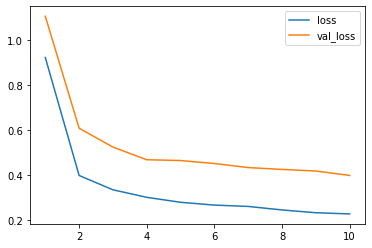

In [31]:
y_val = np.argmax(y_val, axis=1)

y_pred = nn.predict(X_val)

accuracy = accuracy_score(y_pred, y_val)
print("正答率:{}".format(accuracy))

x = np.arange(1, len(nn.list_train_loss)+1)
plt.plot(x, nn.list_train_loss, label="loss")
plt.plot(x, nn.list_test_loss, label="val_loss")
plt.legend()
plt.show()

GPUで実行しようとしたところ、メモリ不足でエラーになった。扱うデータは同じだが畳込みの部分で一時的に扱うデータ量を増やしているので、その影響が出たと思われるが今は放置。